#Data 

In [ ]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

## 사진 400장 train/test set 나누기


In [ ]:
def train_test(test_a,test_b):
  subject_train=[]
  for i in range(1,test_a):
    path = '/home/enter1994/dataset/att_faces/s'+str(i)
    file_list = os.listdir(path)
    for j in range(10):
      with Image.open(path+"/"+file_list[j]) as im:
        a= np.asarray(im)
        new_a=a.reshape(112*92,)
        subject_train.append(new_a)
  
  for i in range(test_b,41):
    path = '/home/enter1994/dataset/att_faces/s'+str(i)
    file_list = os.listdir(path)
    for j in range(10):
      with Image.open(path+"/"+file_list[j]) as im:
        a= np.asarray(im)
        new_a=a.reshape(112*92,)
        subject_train.append(new_a)
  subject_train=np.asarray(subject_train)

  subject_test=[]
  for i in range(test_a,test_b):
    path = '/home/enter1994/dataset/att_faces/s'+str(i)
    file_list = os.listdir(path)
    for j in range(10):
      with Image.open(path+"/"+file_list[j]) as im:
        a= np.asarray(im)
        new_a=a.reshape(112*92,)
        subject_test.append(new_a)
  subject_test=np.asarray(subject_test)
  
  return subject_train,subject_test

In [ ]:
def plot_faces(pixels):
    fig, axes = plt.subplots(5, 20, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(112, 92), cmap='gray')
    plt.show()

#plot_faces(subject_train)

In [ ]:
def pointDist(x,y):
  sum=0
  for i in range(len(x)):
    sum+=(x[i]-y[i])**2
  dist=sum**(1/2)
  return dist


#LDA

##Fisher *face*

In [ ]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
subject=train_test(1,5)
subject_train=subject[0].reshape(36,10,10304)
subject_test=subject[1].reshape(4,10,10304)

In [ ]:
subject_train.shape

(36, 10, 10304)

In [ ]:
def scatter(data):
  average_class=[]
  for i in range(len(data)):
      mean = np.mean(data[i], axis=0, keepdims=True)
      average_class.append(mean)
      
  average_class = np.asarray(average_class)

  s_w=0
  for s in range(len(data)):
      s1=0
      for i in range(len(data[s])):
        s1+=np.matmul((data[s][i]-average_class[s]).T,data[s][i]-average_class[s])
      s_w+=s1
  #s_w=s_w/40 #40
  mu= np.mean(average_class,axis=0)
  s_b=0
  for cc in range(len(data)):
    #s_b+=10*np.matmul((average_class[cc]-mu).T,average_class[cc]-mu)#10
    s_b+=np.matmul((average_class[cc]-mu).T,average_class[cc]-mu)  
  #s_b=s_b/40 #40
  return s_w,s_b

In [ ]:
class my_lda():

    def __init__(self, N):
        #N(축소시킬 차원)
        self.N = N
        self.eigen_matrics = None
        self.eigen_value = None
        
    def get_eigen(self, data):
        data=data.reshape(len(data),10,10304)
        #data=data.reshape(2,5,2)
        s_ex_w=scatter(data)[0]
        s_ex_b=scatter(data)[1]
        s_w_inverse=np.linalg.pinv(s_ex_w)
        
        #data=data.reshape(len(data),10304)
        #data=data.reshape(10,2)        
        #n, d = data.shape # 400,10304
        d=10304
        eigen=np.matmul(s_w_inverse,s_ex_b)
        # np.linalg.eigh 이용해서
        #eigen value, eigen vector 계산하기
        eigvalues, eigvectors = np.linalg.eigh(eigen) 
        
        # eigen value와 vectors 짝지어서 저장.
        eigen_values_vectors = [(eigvalues[a], eigvectors[:, a]) for a in range(d)]
        
        # eigen value 값에 따라 내림차순 정렬 
        eigen_sorting = sorted(eigen_values_vectors, key=lambda tup: tup[0], reverse=True)
        
        # eigen vector 쌓아서 행렬 만들기. 
        self.eigen_matrics = np.stack(list(map(lambda tup: tup[1], eigen_sorting)), axis=1)
        
        # eigen value 모아서 벡터 만들기. 
        self.eigen_values = np.array(list(map(lambda tup: tup[0], eigen_sorting)))
        
        #sorting 안하고 순서대로 eigen matrics 뽑은거
        self.eigen_not_sorting_matrics = np.stack(list(map(lambda tup: tup[1], eigen_values_vectors)), axis=1)

    def dimension_reduction(self, data):
        
        # N개의 eigen vector로 행렬만들기.
        N_eigen_matrics = self.eigen_matrics[:, :self.N]
        
        # 차원 축소해서 정사영시킨 결과값들.
        final_y = np.matmul(data, N_eigen_matrics)

        return final_y,N_eigen_matrics, self.eigen_matrics, self.eigen_not_sorting_matrics

In [ ]:
def result_lda(data,N_d):
  lda = my_lda(N=N_d)
  #eigen vector 구하기
  lda.get_eigen(data)

  #주성분 축 행렬로 만들기 and 확인
  N_eigen_matrics = lda.dimension_reduction(data)[1]
  #N_eigen_matrics.shape

  #차원축소 잘되었는지 확인
  final_y=lda.dimension_reduction(data)[0]
  #print(final_y.shape)
  eigen_matrics=lda.dimension_reduction(data)[2]

  #eigenface_vectors=N_eigen_matrics.T[0].reshape(112,92)
  #plt.imshow(eigenface_vectors)
  return N_eigen_matrics,final_y,eigen_matrics

In [ ]:
N_d=3
data= subject_train
lda = my_lda(N=N_d)
#eigen vector 구하기
lda.get_eigen(data)

#주성분 축 행렬로 만들기 and 확인
N_eigen_matrics = lda.dimension_reduction(data)[1]
#N_eigen_matrics.shape

#차원축소 잘되었는지 확인
final_y=lda.dimension_reduction(data)[0]
#print(final_y.shape)
eigen_matrics=lda.dimension_reduction(data)[2]

#eigenface_vectors=N_eigen_matrics.T[0].reshape(112,92)
#plt.imshow(eigenface_vectors)
#return N_eigen_matrics,final_y,eigen_matrics

In [ ]:
results=result_lda(subject_train,3)
N_eigen_matrics,final_y,eigen_matrics_L=results[0],results[1],results[2]


In [ ]:
print(N_eigen_matrics.shape)
print(final_y.shape)
print(eigen_matrics_L.shape)

(10304, 3)
(36, 10, 3)
(10304, 10304)


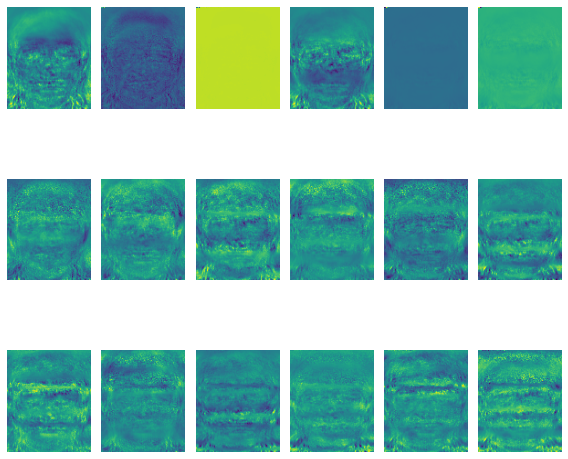

In [ ]:
#사진그리기
subject_train=subject_train.reshape(360,10304)
def draw_origin(rows,cols,pixel):

    axes=[]
    fig=plt.figure(figsize=(25, 8))

    for a in range(rows*cols):
        b =pixel[a].reshape(112,92)
        axes.append( fig.add_subplot(rows, cols, a+1) )
        plt.axis('off')
        plt.imshow(b)
    plt.show()
def draw_projection(rows,cols,pixel):      
    axes=[]
    fig=plt.figure(figsize=(8, 8))
    for a in range(rows*cols):
        b =pixel.T[a].reshape(112,92)
        axes.append( fig.add_subplot(rows, cols, a+1) )
        plt.axis('off')
        plt.imshow(b)
    fig.tight_layout()    
    plt.show()

#draw_origin(3,4,subject_test)
draw_projection(3,6,eigen_matrics_L)

##3D LDA space scatter

In [ ]:
final_y = np.matmul(subject_test, N_eigen_matrics)
final_y=final_y.reshape(40,3)

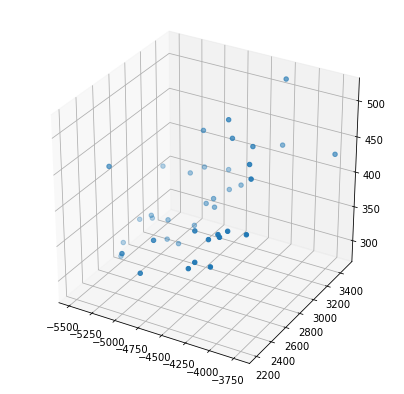

In [ ]:
draw_scatter(final_y)

##query and gallery(lda)

In [ ]:
def ten_fold(sss,N_d):
    subject=train_test(sss,sss+4)
    subject_train=subject[0].reshape(36,10,10304)
    subject_test=subject[1].reshape(4,10,10304)
    
    results=result_lda(subject_train,N_d)
    N_eigen_matrics=results[0]
    final_y = np.matmul(subject_test, N_eigen_matrics)
    
    final_y_test=final_y.reshape(40,N_d)

    subject1=final_y_test[:10,:]
    subject2=final_y_test[10:20,:]
    subject3=final_y_test[20:30,:]
    subject4=final_y_test[30:41,:]

    subject_gallery=[]
    subject_gallery.append(subject1[3:11,:])
    subject_gallery.append(subject2[3:11,:])
    subject_gallery.append(subject3[3:11,:])
    subject_gallery.append(subject4[3:11,:])

    subject_gallery=np.asarray(subject_gallery).reshape(28,N_d)

    subject_query=[]
    subject_query.append(subject1[:3,:])
    subject_query.append(subject2[:3,:])
    subject_query.append(subject3[:3,:])
    subject_query.append(subject4[:3,:])
    subject_query=np.asarray(subject_query).reshape(12,N_d)

    dist=[]
    for abc in range(len(subject_query)):
          for gq in range(len(subject_gallery)):
                  dist.append(pointDist(subject_query[abc],subject_gallery[gq]))
    dist=np.asarray(dist)
    dist=dist.reshape(12,28)
    knn=np.argsort(dist, axis=1)[:, :7] 
    labeledKNN = knn//7

    c = []
    for row in labeledKNN:
      temp = [0 for i in range(4)]
      for i in range(7):
        temp[row[i]]+=1
      c.append(temp)
      
    splitedC = np.split(np.array(c), 4, axis=0)
    pred = []
    for row in splitedC:
      pred.append(np.sum(row, axis=0))
    pred=np.array(pred)/21.*100
    return pred

In [ ]:
def TF(N_d):
  
  PPP=[]
  for i in range(1,38,4):
    PPP.append(ten_fold(i,N_d))
  PPP=np.array(PPP)
  Final=np.sum(PPP,axis=0)/10
  print("FINAL_CONFUSION_MATRICS",Final)

  accuracy=0
  for i in range(4):
    accuracy+=Final[i][i]
  accuracy=accuracy/4 
  print("accuracy",accuracy)
  return Final ,accuracy



###Dimension 10일때 Confusion matrix

In [ ]:
r10=TF(10)
r10



FINAL_CONFUSION_MATRICS [[90.47619048  2.38095238  0.          7.14285714]
 [ 0.95238095 93.80952381  4.28571429  0.95238095]
 [ 6.19047619  2.38095238 79.04761905 12.38095238]
 [ 2.38095238  5.71428571 10.95238095 80.95238095]]
accuracy 86.07142857142858


'\nFINAL_CONFUSION_MATRICS [[66.33333333 11.66666667 10.33333333 11.66666667]\n [21.33333333 65.33333333  8.          5.33333333]\n [12.66666667 10.         64.33333333 13.        ]\n [16.          7.66666667 12.33333333 64.        ]]\naccuracy 65.0\n'

###Dimension 50일때 Confusion matrix

In [ ]:
r50=TF(50)
r50
'''
FINAL_CONFUSION_MATRICS [[66.66666667 15.33333333  8.33333333  9.66666667]
 [22.33333333 67.          6.66666667  4.        ]
 [13.33333333 10.         64.33333333 12.33333333]
 [15.66666667  9.33333333  9.66666667 65.33333333]]
accuracy 65.83333333333334
'''

FINAL_CONFUSION_MATRICS [[92.38095238  4.28571429  0.          3.33333333]
 [ 1.42857143 96.66666667  0.95238095  0.95238095]
 [ 8.57142857  1.9047619  79.52380952 10.        ]
 [ 1.42857143  3.80952381  8.57142857 86.19047619]]
accuracy 88.69047619047618


'\nFINAL_CONFUSION_MATRICS [[66.66666667 15.33333333  8.33333333  9.66666667]\n [22.33333333 67.          6.66666667  4.        ]\n [13.33333333 10.         64.33333333 12.33333333]\n [15.66666667  9.33333333  9.66666667 65.33333333]]\naccuracy 65.83333333333334\n'



###Dimension 100일때 Confusion matrix

In [ ]:
r100=TF(100)
r100
'''
FINAL_CONFUSION_MATRICS [[66.33333333 17.          8.33333333  8.33333333]
 [22.         68.          5.33333333  4.66666667]
 [15.33333333 10.         63.66666667 11.        ]
 [18.          7.33333333  9.33333333 65.33333333]]
accuracy 65.83333333333333
'''

FINAL_CONFUSION_MATRICS [[92.38095238  4.28571429  0.47619048  2.85714286]
 [ 1.42857143 96.66666667  0.95238095  0.95238095]
 [ 8.57142857  1.9047619  78.57142857 10.95238095]
 [ 0.47619048  3.80952381  8.57142857 87.14285714]]
accuracy 88.69047619047618


'\nFINAL_CONFUSION_MATRICS [[66.33333333 17.          8.33333333  8.33333333]\n [22.         68.          5.33333333  4.66666667]\n [15.33333333 10.         63.66666667 11.        ]\n [18.          7.33333333  9.33333333 65.33333333]]\naccuracy 65.83333333333333\n'

##축소한 차원에 따른 성능 비교 결과 

"LDA를 n차원으로 축소했을 때 정확도 표"

In [1]:
import pandas as pd
accuracy=[73.57,86.07,88.70,88.70]
raw_data = {'Dimension':accuracy}
df = pd.DataFrame(accuracy, columns = ['LDA_Accuracy'],
                  index=['d=3', 'd=10', 'd=50', 'd=100'])
print(df)
print("")

       LDA_Accuracy
d=3           73.57
d=10          86.07
d=50          88.70
d=100         88.70

